In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats

#### Setup and Pre-Processing

In [2]:
# Reading in eclipse dataset
eclipse_df = pd.read_csv("data/solar.csv")
eclipse_df.columns = eclipse_df.columns.str.replace(pat=" ", repl="_")
eclipse_df = eclipse_df.drop(["Path_Width_(km)","Central_Duration"], axis=1)

In [3]:
# Reading in weather dataset
weather_df = pd.read_parquet("data/daily_weather.parquet")
cities_df = pd.read_csv("data/cities.csv")
countries_df = pd.read_csv("data/countries.csv")

### 1. Estimating Cloud Cover

In [4]:
# Grouping cities into their nearest latitude and longitude regions
cities_df.latitude = cities_df.latitude.apply(round)
cities_df.longitude = cities_df.longitude.apply(round)

In [5]:
# Adding positional data to weather dataset
weather_df = weather_df.join(other=cities_df, lsuffix='_cities', rsuffix="_weather")

In [6]:
# Generating ggregate statistics for the sunshine-minutes confidence intervals
weather_point_est_df = weather_df.groupby(['latitude','longitude'])['sunshine_total_min'].agg(['mean', 'count', 'std'])
t_values = stats.t.ppf(0.975, weather_point_est_df['count'] - 1)
error_bounds = t_values * weather_point_est_df['std'] / (weather_point_est_df['count'] ** 0.5)
weather_point_est_df['conf_int_lower'] = weather_point_est_df['mean'] - error_bounds
weather_point_est_df['conf_int_upper'] = weather_point_est_df['mean'] + error_bounds
weather_point_est_df[["mean","count","conf_int_lower","conf_int_upper"]].describe()

,mean,count,conf_int_lower,conf_int_upper
count,1176.000000,1176.000000,1176.000000,1176.000000
mean,289.988769,10.442177,98.853835,481.123703
std,95.719433,3.387344,96.034929,125.453309
min,43.714286,6.000000,-148.220855,112.778478
25%,223.660714,7.000000,32.650058,395.800255
50%,291.500000,11.000000,93.594910,487.793589
75%,355.309091,12.000000,166.414526,566.367666
max,644.727273,34.000000,498.086528,886.830847


In [7]:
# Isolating relevant columns and taking the mean sunshine-minutes by latitude-longitude pair
sunshine_grid = weather_df.loc[:,["latitude",'longitude','sunshine_total_min']].groupby(['latitude','longitude']).mean().sunshine_total_min
# Creating sparse table of mean sunshine-minutes by latitude and longitude
sunshine_grid = sunshine_grid.reset_index(level=1)
sunshine_pivot = sunshine_grid.pivot_table(values="sunshine_total_min", index=sunshine_grid.index, columns="longitude")

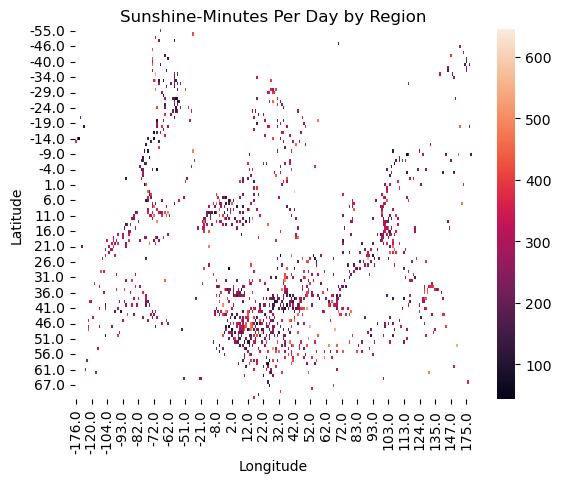

In [8]:
# Displaying plot of sunshine-minutes
sns.heatmap(sunshine_pivot)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Sunshine-Minutes Per Day by Region")
plt.show()

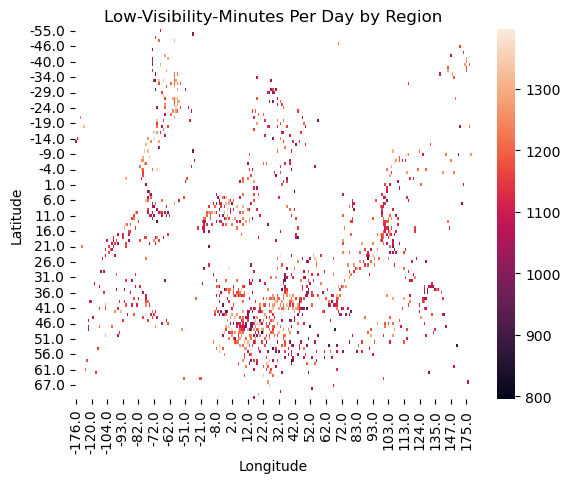

In [9]:
# Displaying plot of low-visibility-minutes
sns.heatmap(sunshine_pivot.apply(lambda x: 1440-x))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Low-Visibility-Minutes Per Day by Region")
plt.show()

### 2. Estimating Eclipse Frequency by Latitude/Longitude

In [10]:
# Converting latitude and longitude strings to integer values
def convert_lat_long(pos_string):
    if pos_string[-1] in ('N','E'):
        return round(float(pos_string[:-1]))
    else:
        return -1 * round(float(pos_string[:-1]))

eclipse_df.Latitude = eclipse_df.Latitude.apply(convert_lat_long)
eclipse_df.Longitude = eclipse_df.Longitude.apply(convert_lat_long)

In [11]:
# Displaying eclipse types
eclipse_df.groupby("Eclipse_Type").count().Catalog_Number
# Too much specificity. Should be binned to focus on total eclipses.

Eclipse_Type
A     3755
A+      34
A-      34
Am      72
An      36
As      25
H      502
H2      24
H3      26
Hm      17
P     3875
Pb     163
Pe     162
T     3049
T+       9
T-      17
Tm      72
Tn      14
Ts      12
Name: Catalog_Number, dtype: int64

In [12]:
# Binning all eclipses into total, annular, partial, and hybrid eclipses
simple_eclipse_df = eclipse_df.copy(deep=True)
simple_eclipse_df.Eclipse_Type = eclipse_df.Eclipse_Type.apply(lambda ecl_type: ecl_type[0])

In [13]:
# Isolating out only total eclipse data
total_eclipse_df = simple_eclipse_df[simple_eclipse_df.Eclipse_Type == 'T']

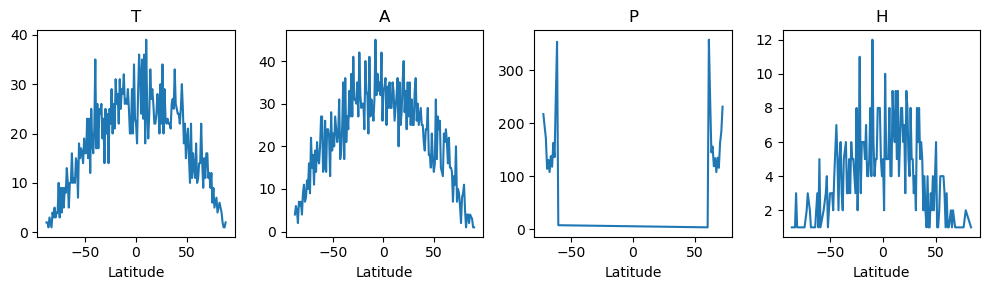

In [14]:
# Computing distribution of eclipses by latitude and type
fig, axes = plt.subplots(1,4,figsize=(10,3))
for ind, ecl_type in enumerate(simple_eclipse_df.Eclipse_Type.unique()):
    #simple_eclipse_df[simple_eclipse_df.Eclipse_Type == ecl_type].groupby("Latitude").count().Catalog_Number.plot(kind="bar", ax=axes[ind])
    simple_eclipse_df[simple_eclipse_df.Eclipse_Type == ecl_type].groupby("Latitude").count().Catalog_Number.plot.line(ax=axes[ind])
    axes[ind].set_title(label=f"{ecl_type}")
plt.tight_layout()
plt.show()

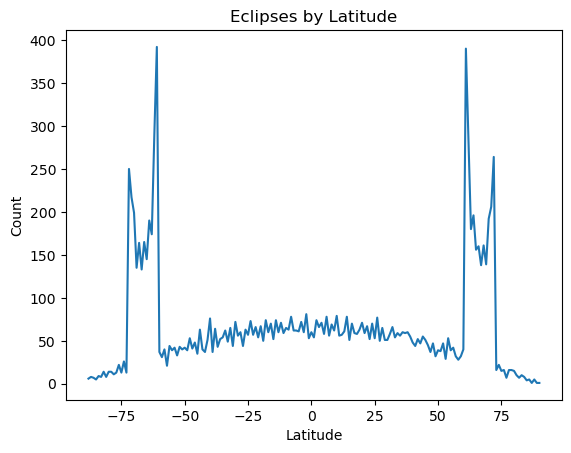

In [15]:
# Computing overall distribution of eclipses
simple_eclipse_df.groupby("Latitude").count().Catalog_Number.plot.line()
plt.title("Eclipses by Latitude")
plt.ylabel("Count")
plt.show()

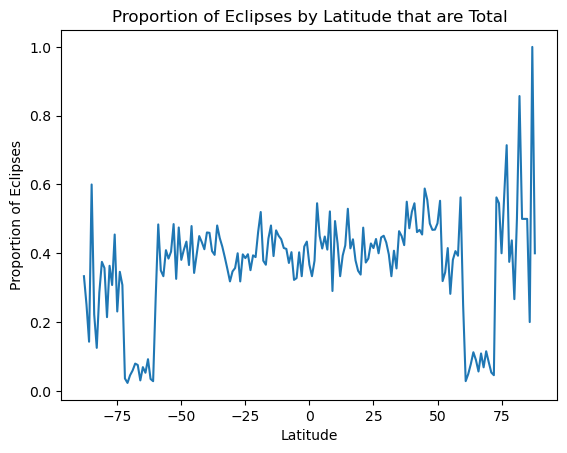

In [16]:
# Proportion of eclipses by latitude that are total eclipses
(simple_eclipse_df[simple_eclipse_df.Eclipse_Type == "T"].groupby("Latitude").count().Catalog_Number / \
 simple_eclipse_df.groupby("Latitude").count().Catalog_Number).dropna().plot.line()
plt.title("Proportion of Eclipses by Latitude that are Total")
plt.ylabel("Proportion of Eclipses")
plt.show()

In [17]:
# Obtaining the counts of total eclipses by latitude
T_series = simple_eclipse_df[simple_eclipse_df.Eclipse_Type == "T"].groupby("Latitude").count().Catalog_Number

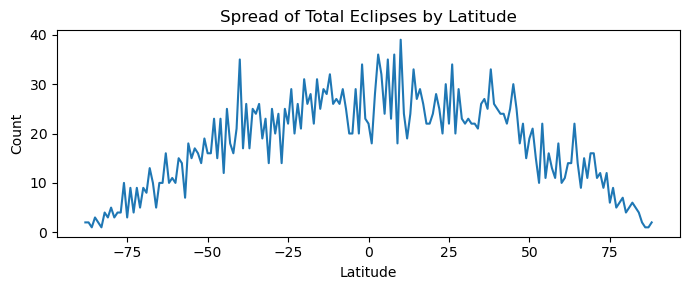

In [18]:
# Plotting total eclipses by latitude
plt.figure(figsize=(7,3))
simple_eclipse_df[simple_eclipse_df.Eclipse_Type == "T"].groupby("Latitude").count().Catalog_Number.plot.line()
plt.xlabel("Latitude")
plt.ylabel("Count")
plt.title("Spread of Total Eclipses by Latitude")
plt.tight_layout()
plt.show()

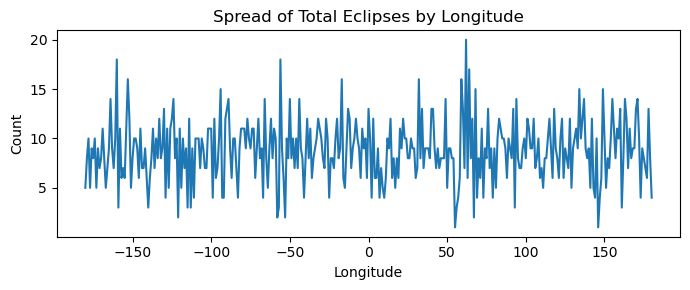

In [19]:
# Plotting total eclipses by longitude
plt.figure(figsize=(7,3))
simple_eclipse_df[simple_eclipse_df.Eclipse_Type == "T"].groupby("Longitude").count().Catalog_Number.plot.line()
plt.xlabel("Longitude")
plt.ylabel("Count")
plt.title("Spread of Total Eclipses by Longitude")
plt.tight_layout()
plt.show()

In [20]:
# Generating eclipse dataset binned by larger region sizes
eclipse_df_round = eclipse_df.copy()
eclipse_df_round.Latitude = eclipse_df_round.Latitude.apply(lambda x: 5 * round(x/5))
eclipse_df_round.Longitude = eclipse_df_round.Longitude.apply(lambda x: 5 * round(x/5))

In [21]:
# Creatng pivot table of eclipse counts by large region
eclipse_df_round_group = eclipse_df_round.groupby(['Latitude','Longitude']).count().Catalog_Number
eclipse_df_round_pivot = eclipse_df_round_group.reset_index(level=1)
eclipse_df_round_pivot = eclipse_df_round_pivot.pivot_table(values="Catalog_Number", index=eclipse_df_round_pivot.index, columns="Longitude")
eclipse_df_round_pivot = eclipse_df_round_pivot.fillna(0)

In [22]:
# Performing ANOVA test of equal means across latitudes
counts_by_lat = [eclipse_df_round_pivot.iloc[ind,:].tolist() for ind in range(eclipse_df_round_pivot.shape[0])]
stats.f_oneway(*counts_by_lat)

F_onewayResult(statistic=216.42074647413443, pvalue=0.0)

In [23]:
# Performing ANOVA test of equal means across longitudes
counts_by_long = [eclipse_df_round_pivot.iloc[:,ind].tolist() for ind in range(eclipse_df_round_pivot.shape[1])]
stats.f_oneway(*counts_by_long)

F_onewayResult(statistic=0.49915739865986253, pvalue=0.9998679095136809)

### 3. Determining Ideal Viewing Location

In [24]:
# Converting daily minutes of sunshine to eclipses-per-daily-minutes-obscured
non_visible_pivot = sunshine_pivot.apply(lambda x: 1440-x) # Converting min. sunshine to min. obscured
viewing_ratio_df = non_visible_pivot.div(T_series, axis=0) # Dividing by total eclipse count
viewing_ratio_df = viewing_ratio_df.apply(lambda x: x**-1) # Inverting ratio

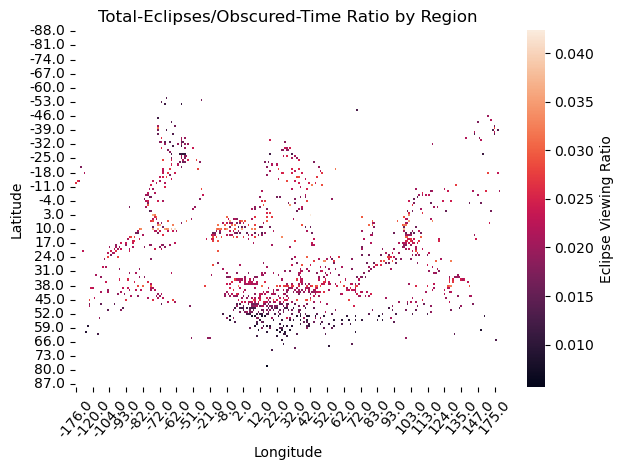

In [25]:
# Plotting total-eclipses-per-cloud-cover by lat. and long.
sns.heatmap(viewing_ratio_df)
plt.title("Total-Eclipses/Obscured-Time Ratio by Region")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xticks(rotation=50)
axis = plt.gca()
cbar = axis.collections[-1].colorbar 
cbar.set_label('Eclipse Viewing Ratio')
plt.tight_layout()
plt.show()

In [26]:
# Finding regions with highest eclipse viewing ratio
highest_viewing_ratios = viewing_ratio_df.max().sort_values(ascending=False).head(10)
best_viewing_coords = viewing_ratio_df.idxmax().loc[highest_viewing_ratios.head(5).index].reset_index()
best_viewing_coords.columns = ['longitude','latitude']
best_viewing_coords = best_viewing_coords.reindex(['latitude','longitude'], axis=1)
best_viewing_coords.loc[:,'Location'] = ["West Somalia",
                                         "North Venezuela",
                                         "North Venezuela",
                                         "South Thailand",
                                         "North Columbia"]
best_viewing_coords.index = best_viewing_coords.index + 1
best_viewing_coords.index.name = "Eclipse View Ranking"
best_viewing_coords

,latitude,longitude,Location
Eclipse View Ranking,,,
1,3.0,42.0,West Somalia
2,10.0,-63.0,North Venezuela
3,10.0,-65.0,North Venezuela
4,10.0,99.0,South Thailand
5,10.0,-76.0,North Columbia


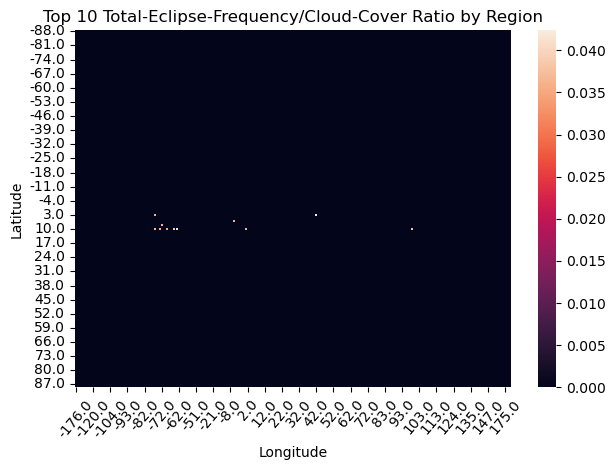

In [28]:
# Displaying 10 regions with highest eclipse viewing ratio
sns.heatmap(sunshine_pivot.apply(lambda x: 1440-x).div(T_series, axis=0).apply(lambda x: x**-1).map(lambda x: x if x>= 0.035396 else 0))
plt.title("Top 10 Total-Eclipse-Frequency/Cloud-Cover Ratio by Region")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xticks(rotation=50)
plt.tight_layout()
plt.show()